# 自作LDA (判別分析法)

### データの読み込み

In [1]:
import pandas as pd

# Wineデータ
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                  'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

### データセットの作成

In [2]:
# import
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 学習と検証に分割
X = df_wine.iloc[:, 1:].values
y = df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [3]:
# 標準化
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)  # ※

### クラスごとの平均ベクトルを求める

In [5]:
import numpy as np
np.set_printoptions(precision=4)

# 各クラスごとの平均ベクトル
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label - 1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



### クラス内変動行列を求める

In [7]:
d = 13 # 特徴量の個数

In [13]:
# クラス内変動行列S_w = sum(S_i) S_i・・・各クラスの変動行列
S_W = np.zeros((d, d))

for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))  # クラス内の変動行列(偏差行列)
    for row in X_train_std[y_train==label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1) # 縦ベクトルにする
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter

print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))
print(S_W)

Within-class scatter matrix: 13x13
[[ 5.0722e+01  3.1007e+00 -7.9323e+00 -5.7848e+00 -2.8879e+00  7.8990e+00
   2.4543e+00  9.3932e-01  9.0781e-01  1.5486e+01  7.0293e+00 -1.8659e+00
   4.9370e+00]
 [ 3.1007e+00  9.0179e+01  4.7074e+00  1.4750e+01 -1.0900e+01 -8.8059e-02
   9.7797e-01  8.4547e+00  4.4732e+00 -1.4494e+01 -2.0361e+01  3.5876e+00
  -1.1176e+01]
 [-7.9323e+00  4.7074e+00  1.1189e+02  7.0126e+01  2.2213e+01  1.5505e+01
   1.4856e+01  2.0454e+01 -2.3344e+00  1.3787e+00  5.6585e+00  8.1917e+00
   3.2570e-01]
 [-5.7848e+00  1.4750e+01  7.0126e+01  9.2147e+01  1.2485e+01  6.2091e+00
   6.2783e+00  1.2735e+01 -4.7597e+00 -4.1511e+00  1.1779e+00  1.1633e+01
  -4.5296e+00]
 [-2.8879e+00 -1.0900e+01  2.2213e+01  1.2485e+01  1.0605e+02  1.0950e+01
   5.2875e+00 -2.1136e+01  1.3076e+01  5.9930e+00  8.4568e+00 -5.3128e-01
   1.1845e+01]
 [ 7.8990e+00 -8.8059e-02  1.5505e+01  6.2091e+00  1.0950e+01  5.7194e+01
   2.8971e+01 -7.4850e+00  3.0810e+01  1.5516e+01  6.6816e-01  1.9382e+01
  

### トレーニングデータのクラス分布

In [14]:
print('Class label distribution: %s' % np.bincount(y_train))
print('Class label distribution: %s' % np.bincount(y_train)[1:])

Class label distribution: [ 0 41 50 33]
Class label distribution: [41 50 33]


### 共分散行列

In [15]:
# クラスの頻度の偏りをなくした変動行列＝sum(各クラスの共分散行列)
S_W_cov = np.zeros((d, d))

for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W_cov += class_scatter
    
print(S_W_cov.shape)
print(S_W_cov) # scaled

(13, 13)
[[ 1.2448  0.0967 -0.1276 -0.1105 -0.0726  0.2374  0.0753  0.0231  0.1102
   0.4261  0.1411 -0.0155  0.1224]
 [ 0.0967  2.2666  0.1168  0.3517 -0.2622 -0.0467 -0.0186  0.2194  0.0187
  -0.3939 -0.4167  0.0787 -0.2492]
 [-0.1276  0.1168  2.6024  1.6442  0.5364  0.3947  0.3191  0.4553 -0.0353
   0.06    0.167   0.1987 -0.0081]
 [-0.1105  0.3517  1.6442  2.1604  0.325   0.1535  0.1222  0.273  -0.0824
  -0.068   0.0336  0.2548 -0.1201]
 [-0.0726 -0.2622  0.5364  0.325   2.4397  0.2384  0.1433 -0.5166  0.2566
   0.1445  0.1777 -0.0058  0.2509]
 [ 0.2374 -0.0467  0.3947  0.1535  0.2384  1.352   0.6416 -0.0781  0.7644
   0.4392  0.0177  0.4359  0.1554]
 [ 0.0753 -0.0186  0.3191  0.1222  0.1433  0.6416  0.6968 -0.2588  0.5765
   0.3851 -0.0408  0.2525  0.0748]
 [ 0.0231  0.2194  0.4553  0.273  -0.5166 -0.0781 -0.2588  2.1795 -0.2801
  -0.0363  0.1208 -0.332  -0.1485]
 [ 0.1102  0.0187 -0.0353 -0.0824  0.2566  0.7644  0.5765 -0.2801  2.1792
   0.6795 -0.1815  0.2323  0.1568]
 [ 0.4261 

### クラス間変動行列を求める

In [19]:
# 全データによる平均ベクトル
mean_overall = np.mean(X_train_std, axis=0)

In [21]:
# クラス間変動行列
S_B = np.zeros((d, d))

for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train==i+1, :].shape[0] # 特定のクラスラベルに属するデータ数を取得
    mean_vec = mean_vec.reshape(d, 1)         # クラス内平均の列ベクトルを作成
    mean_overall = mean_overall.reshape(d, 1) # 全体平均の列ベクトルを作成
    
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
    
print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))
print(S_B)

Between-class scatter matrix: 13x13
[[ 73.2779   5.1521  29.3409 -37.8053  35.3288  27.8688  24.4037 -10.917
   11.9293  51.2816   0.2198  -0.3445  73.9711]
 [  5.1521  33.8209   5.5342  17.6688  -3.0595 -41.4067 -51.4514  32.9397
  -31.0444  36.0237 -47.4845 -53.4785 -18.4551]
 [ 29.3409   5.5342  12.1084 -13.0286  13.5707   6.6597   4.2554  -0.8742
    1.4687  23.8967  -4.84    -5.6837  27.1642]
 [-37.8053  17.6688 -13.0286  31.8532 -21.5944 -40.7237 -44.8903  26.1101
  -25.5242  -6.7623 -28.9705 -32.2968 -52.5343]
 [ 35.3288  -3.0595  13.5707 -21.5944  17.9512  20.621   20.5742 -10.8479
   11.0338  19.3529   7.9757   8.6902  39.5823]
 [ 27.8688 -41.4067   6.6597 -40.7237  20.621   66.8061  78.1916 -47.8401
   45.861  -22.5142  61.6487  69.1515  58.7931]
 [ 24.4037 -51.4514   4.2554 -44.8903  20.5742  78.1916  92.6119 -57.1978
   54.6364 -34.4354  75.5525  84.8261  62.2248]
 [-10.917   32.9397  -0.8742  26.1101 -10.8479 -47.8401 -57.1978  35.584
  -33.8973  25.0189 -47.8855 -53.8    

### クラス内変動行列とクラス間変動行列である行列を作る

In [28]:
# ある行列 inv(S_W)(S_B)
Mat = np.linalg.inv(S_W).dot(S_B)
print(Mat)

[[ 1.3779 -0.1453  0.5266 -0.858   0.7044  0.8379  0.8436 -0.4492  0.4551
   0.7297  0.3479  0.3804  1.5622]
 [ 0.2932  0.4726  0.1643  0.1233  0.0665 -0.4743 -0.6206  0.4117 -0.383
   0.6432 -0.6408 -0.7235 -0.0236]
 [ 0.9462  0.2559  0.3985 -0.3731  0.4248  0.1144  0.0142  0.0498 -0.0264
   0.8456 -0.266  -0.307   0.8212]
 [-1.1192  0.2322 -0.4159  0.7663 -0.5911 -0.8287 -0.8668  0.48   -0.4785
  -0.482  -0.4448 -0.4915 -1.3497]
 [ 0.2082 -0.0096  0.0809 -0.1221  0.1044  0.1106  0.1078 -0.0554  0.057
   0.1223  0.035   0.0377  0.2273]
 [-0.5524  0.5341 -0.1617  0.633  -0.3612 -0.9526 -1.0943  0.6594 -0.6358
   0.1685 -0.815  -0.9127 -0.9627]
 [ 0.5618 -2.5385 -0.0425 -1.856   0.698   3.555   4.2836 -2.6808  2.5481
  -2.1047  3.6616  4.116   2.3898]
 [ 0.1544 -0.2525  0.0345 -0.2396  0.1181  0.4001  0.4699 -0.2883  0.2761
  -0.1471  0.3743  0.42    0.342 ]
 [-0.2032 -0.0394 -0.084   0.0896 -0.0938 -0.0448 -0.0278  0.005  -0.0092
  -0.1665  0.035   0.041  -0.1874]
 [ 0.0841  1.3419  0.

### 変換行列の固有値と固有ベクトルを求める

In [29]:
eigen_vals, eigen_vecs = np.linalg.eig(Mat)
print("固有値 :", eigen_vals)
print("固有ベクトル : ", eigen_vecs)

固有値 : [ 0.0000e+00+0.0000e+00j  4.2257e+00+0.0000e+00j  8.2625e+00+0.0000e+00j
  8.9145e-17+0.0000e+00j -9.2756e-16+0.0000e+00j  5.7890e-16+0.0000e+00j
  3.1729e-16+1.2783e-16j  3.1729e-16-1.2783e-16j -2.1146e-17+1.5342e-16j
 -2.1146e-17-1.5342e-16j -2.8634e-16+0.0000e+00j -1.3966e-16+2.8574e-17j
 -1.3966e-16-2.8574e-17j]
固有ベクトル :  [[ 0.7581+0.j     -0.4077+0.j     -0.1586+0.j      0.7606+0.j
   0.5389+0.j      0.3063+0.j      0.6698+0.j      0.6698-0.j
  -0.3541+0.3916j -0.3541-0.3916j -0.6094+0.j      0.7484+0.j
   0.7484-0.j    ]
 [-0.0974+0.j     -0.1821+0.j      0.0984+0.j     -0.0271+0.j
  -0.5201+0.j      0.6355+0.j      0.0856+0.1162j  0.0856-0.1162j
  -0.0195-0.1803j -0.0195+0.1803j  0.0879+0.j     -0.1288-0.0378j
  -0.1288+0.0378j]
 [-0.2358+0.j     -0.3473+0.j     -0.0156+0.j     -0.2025+0.j
  -0.0576+0.j     -0.5015+0.j     -0.1726-0.1413j -0.1726+0.1413j
   0.5414+0.j      0.5414-0.j     -0.0454+0.j     -0.2957-0.0263j
  -0.2957+0.0263j]
 [ 0.2459+0.j      0.3095+0.j      

### 判別度(固有値の大きさ)を大きい順に並べる

In [30]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

print('Eigenvalues in descending order:\n')
for eigen_val, eigen_vec in eigen_pairs:
    print("固有値 : ", eigen_val)
    print("固有ベクトル : ", eigen_vec)

Eigenvalues in descending order:

固有値 :  8.262493673957483
固有ベクトル :  [-0.1586+0.j  0.0984+0.j -0.0156+0.j  0.1588+0.j -0.0207+0.j  0.1884+0.j
 -0.7153+0.j -0.0798+0.j  0.0074+0.j  0.3448+0.j -0.0254+0.j -0.3192+0.j
 -0.4054+0.j]
固有値 :  4.225659486916686
固有ベクトル :  [-0.4077+0.j -0.1821+0.j -0.3473+0.j  0.3095+0.j -0.064 +0.j  0.0733+0.j
  0.3034+0.j -0.0009+0.j  0.0716+0.j -0.2808+0.j  0.244 +0.j -0.0459+0.j
 -0.5806+0.j]
固有値 :  9.2755649547541e-16
固有ベクトル :  [ 0.5389+0.j -0.5201+0.j -0.0576+0.j  0.1336+0.j  0.0074+0.j  0.3571+0.j
 -0.2896+0.j -0.0173+0.j  0.0027+0.j -0.2399+0.j -0.0732+0.j -0.2471+0.j
 -0.2866+0.j]
固有値 :  5.788968521986873e-16
固有ベクトル :  [ 0.3063+0.j  0.6355+0.j -0.5015+0.j  0.2437+0.j  0.0407+0.j  0.0118+0.j
  0.2003+0.j  0.0683+0.j -0.1052+0.j -0.2384+0.j -0.0894+0.j  0.2503+0.j
  0.0796+0.j]
固有値 :  3.4207348338517877e-16
固有ベクトル :  [ 0.6698+0.j      0.0856+0.1162j -0.1726-0.1413j  0.1409+0.0155j
 -0.0365+0.0268j -0.0415-0.0886j  0.2922+0.1817j -0.0056+0.013j
  0.0637-0.

### 判別性（クラスの判別情報の補足度合い）を可視化

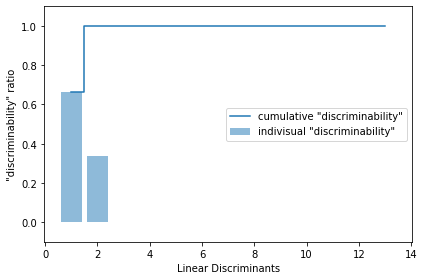

In [31]:
# 判別性（クラスの判別情報の補足度合い）
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr) # 累積

import matplotlib.pyplot as plt
%matplotlib inline

plt.bar(range(1, 14), discr, alpha=0.5, align='center', label='indivisual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid', label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### 変換行列を作成(上位2つの固有値に対応する固有ベクトルを用いて)

In [33]:
# 次元削減用変換行列
transM = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))
print(transM.shape)
print(transM)

(13, 2)
[[-0.1586 -0.4077]
 [ 0.0984 -0.1821]
 [-0.0156 -0.3473]
 [ 0.1588  0.3095]
 [-0.0207 -0.064 ]
 [ 0.1884  0.0733]
 [-0.7153  0.3034]
 [-0.0798 -0.0009]
 [ 0.0074  0.0716]
 [ 0.3448 -0.2808]
 [-0.0254  0.244 ]
 [-0.3192 -0.0459]
 [-0.4054 -0.5806]]


### 次元削減

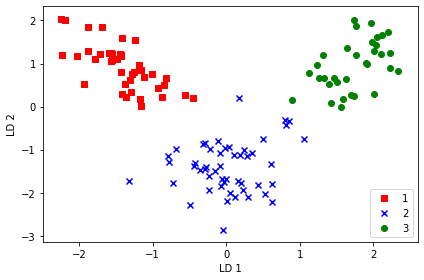

In [35]:
X_train_lda = X_train_std.dot(transM) # 部分空間に写像

# プロット
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0],
               X_train_lda[y_train==l, 1] * (-1),
               c=c,
               label=l,
               marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Scikit-learn LDA

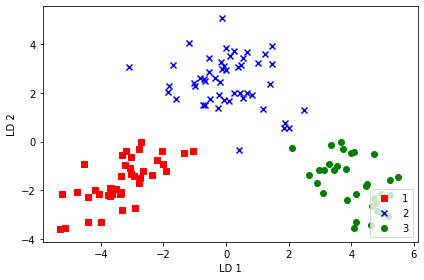

In [36]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0],
               X_train_lda[y_train==l, 1] * (-1),
               c=c,
               label=l,
               marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### 学習データで作った変換行列をテストデータに適用

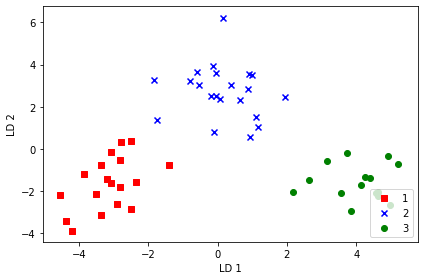

In [37]:
X_test_lda = lda.transform(X_test_std)

colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_test_lda[y_test==l, 0],
               X_test_lda[y_test==l, 1] * (-1),
               c=c,
               label=l,
               marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()